In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from utils import utils, torch_utils

from config import init_args
import data
import models
import librosa
import copy

import json
from moviepy.editor import VideoFileClip
import argparse
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve

In [2]:
# AudioLDM : sample_rate = 16000

def extract_audio(video_path, duration=2):
    clip = VideoFileClip(video_path)
    audio = clip.audio
    wav = audio.to_soundarray(fps=22050)
    if len(wav.shape) == 2:
        wav = np.mean(wav, axis=1)
    diff = wav.shape[0] - (22050 * duration)
    if diff != 0:
        wav = wav[:(22050 * duration)]
        # wav = wav[:441000]
    assert wav.shape[0] == (22050 * duration)
    return wav

def detect_onset(video_dir, duration=2):
    video_list = glob(os.path.join(video_dir, '*.mp4'))
    video_list.sort()
    onset_res = {}
    wav_res = {}
    for video_path in tqdm(video_list):
        idx = int(video_path.split('/')[-1].split('.')[0])
        wav = extract_audio(video_path, duration=duration)
        onsets = librosa.onset.onset_detect(
            wav, sr=22050, units='samples', delta=0.3
        )
        onset_res[idx] = onsets
        wav_res[idx] = wav
        # if idx == 20:
        #     break
    return onset_res, wav_res

In [3]:
conf_interval = int(0.1 * 22050)
sample_rate = 22050
frame_rate = 15
hop_length = int(sample_rate / frame_rate)
conf_interval = librosa.samples_to_time(conf_interval, sr=sample_rate)
conf_interval = librosa.time_to_frames(conf_interval, sr=sample_rate, hop_length=hop_length)
conf_interval

1

In [32]:
def onset_nms(onset, confidence, window=0.05):
    # window sample to frames
    window = 0.1
    sample_rate = 22050
    frame_rate = 15
    hop_length = int(sample_rate / frame_rate)
    window = window * sample_rate
    window = librosa.samples_to_time(window, sr=sample_rate)
    window = librosa.time_to_frames(window, sr=sample_rate, hop_length=hop_length)
    # window : 1
    
    # Non-Maximum Suppression, NMS
    # : Descard the duplicated onset
    onset_remain = onset.tolist()
    output = []
    # descending order of confidence of predicted onset
    sorted_idx = np.argsort(confidence)[::-1]   
    
    for idx in sorted_idx:
        cur = onset[idx]
        if cur not in onset_remain:
            continue
        output.append(cur)
        onset_remain.remove(cur)
        for o in onset_remain:
            # if abs(cur - o) < window * 22050:
            if abs(cur - o) < window:
                onset_remain.remove(o)
    return np.array(sorted(output))


def eval_onsets(onset1, onset2, wav2, delta=0.1, conf_interval=int(0.05*22050), keys=None):
    duration = 10
    
    # conf_interval samples to frames
    # conf_interval = int(0.05 * 22050)
    conf_interval = int(0.05 * 22050)
    sample_rate = 22050
    frame_rate = 15
    hop_length = int(sample_rate / frame_rate)
    conf_interval = librosa.samples_to_time(conf_interval, sr=sample_rate)
    conf_interval = librosa.time_to_frames(conf_interval, sr=sample_rate, hop_length=hop_length)
    # conf_interval frame=1 if input conf_interval=int(0.05*22050)
    
    # sec to frames
    # onset1 = librosa.time_to_frames(onset1, sr=sample_rate, hop_length=hop_length)
    # onset2 = librosa.time_to_frames(onset2, sr=sample_rate, hop_length=hop_length)
    
    wav2 = np.abs(wav2)                                             # min -inf, max inf, 150 len
    wav2 = (wav2 - np.min(wav2)) / (np.max(wav2) - np.min(wav2))    # min 0, max 1, 150 len
    
    if len(wav2) < duration * frame_rate:
        print("wav2 len: ", len(wav2))
        print("wav2 is too short")
        
    # onset2 : frame number of predicted onset
    # confidence : the highest probability in the predicred onset frame
    if conf_interval > 0:
        confidence = [np.max(wav2[max(0, o-conf_interval):min(len(wav2), o+conf_interval)]) for o in onset2 if len(wav2) > 0]
    else:
        confidence = [np.max(wav2[o]) for o in onset2 if len(wav2) > 0]
    
    # onset2 = onset_nms(onset2, confidence)
    onset2_keep = onset2
    onset2_onuse = copy.deepcopy(onset2.tolist())
    onset2_res = [0 for _ in onset2_onuse]
    
    hit_cnt = 0
    y_gt = []
    y_pred = []
    
    # delta sec to frames
    delta = librosa.time_to_frames(delta, sr=sample_rate, hop_length=hop_length) # 1 when delta=0.1

    for o in onset1:
        # frame level difference between onset1 and onset2
        diff = [abs(o2 - o) for o2 in onset2_onuse]
        
        idx_in_window = [idx for idx in range(len(onset2_onuse)) if diff[idx] < delta]
        
        if len(idx_in_window) == 0:
            y_gt.append(1)
            y_pred.append(0)
        else:
            conf_in_window = [wav2[onset2_onuse[idx]] for idx in idx_in_window]
            max_conf_idx = np.argsort(conf_in_window)[-1]
            match_idx = idx_in_window[max_conf_idx]
            hit_cnt += 1
            y_gt.append(1)
            
            if conf_interval > 0:
                conf = np.max(wav2[max(0, onset2_onuse[match_idx]-conf_interval):min(len(wav2), onset2_onuse[match_idx]+conf_interval)])
            else:
                conf = np.max(wav2[onset2_onuse[match_idx]])
                
            for i in range(len(onset2_keep)):
                if onset2_keep[i] == onset2_onuse[match_idx]:
                    onset2_res[i] = 1
            y_pred.append(conf)
            onset2_onuse.remove(onset2_onuse[match_idx])
            if len(onset2_onuse) == 0:
                break
            
    for o in onset2_onuse:
        y_gt.append(0)
        if conf_interval > 0:
            y_pred.append(np.max(wav2[max(0, o-conf_interval):min(len(wav2), o+conf_interval)]))
        else:
            y_pred.append(np.max(wav2[o]))
    
    acc = hit_cnt / len(onset1) if len(onset1) != 0 else 0
    ap = average_precision_score(y_gt, y_pred)
    pr, rc, th = precision_recall_curve(y_gt, y_pred)
    
    if keys != None and args.plt:
        plt.plot(rc, pr)
        plt.ylim((0, 1))
        plt.savefig(f'tmp/pc_rc_curve_tar_{keys[0]}_cond_{keys[1]}.jpg')
        plt.close()

    return acc, ap, onset2_res, y_gt, y_pred

Removed samples (less than 150.0 frames) : 0
Greatesthit Dataloader: # sample of test: 4041
=> loading checkpoint '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep40.pth.tar'
=> loaded checkpoint '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep40.pth.tar' (epoch 40)
Overall Test Set - Accuracy: 0.66, AP: 0.70
Precision: [0.64625428 0.55279864 0.55280593 ... 0.9375     1.         1.        ]
Recall: [1.00000000e+00 6.48937159e-01 6.48937159e-01 ... 2.32399603e-04
 2.32399603e-04 0.00000000e+00]


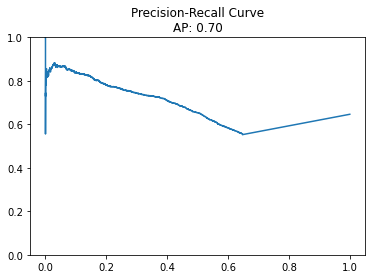

In [33]:
# Model checkpoint
checkpoint_path = '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep40.pth.tar'
args = init_args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = data.GreatestHitDataset(args, split='test')
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False)

net = models.VideoOnsetNet(pretrained=False).to(device)

# load the trained model weights
net, _ = torch_utils.load_model(checkpoint_path, net, device=device, strict=True)
net.eval()

all_y_gt = []
all_y_pred = []
all_acc = []

for step, batch in enumerate(test_loader):
    inputs = {'frames': batch['frames'].to(device)}
    
    with torch.no_grad():
        pred = net(inputs)
    
    # ground truth onsets
    target = batch['label'].to(device)
    target_np = target.cpu().numpy()
    pred_np = pred.cpu().numpy()
    
    # sigmoid to pred_np
    logits = pred_np[0]                                 # min -inf, max inf
    pred_prob = 1 / (1 + np.exp(-pred_np))              # sigmoid : min 0, max 1
    pred_np = np.where(pred_prob > 0.5, 1.0, 0.0)       # binary : min 0, max 1

    # target_np to frame
    target_frames = np.where(target_np[0] == 1)[0]
    target_times = librosa.samples_to_time(target_frames, sr=15)
    
    # pred_np to frame
    pred_frames = np.where(pred_np[0] == 1)[0]
    pred_times = librosa.samples_to_time(pred_frames, sr=15)
    
    onset1 = target_frames          # gt (min 0, max 149, len: num of gt onsets) (15fps, 10sec)
    onset2 = pred_frames            # pred (min 0, max 149, len: num of pred onsets) (15fps, 10sec)
    
    acc, ap, onset2_res, y_gt, y_pred = eval_onsets(onset1, onset2, logits)
    
    all_y_gt.extend(y_gt)
    all_y_pred.extend(y_pred)
    all_acc.append(acc)
    
overall_acc = np.mean(all_acc)
overall_ap = average_precision_score(all_y_gt, all_y_pred)
pr, rc, th = precision_recall_curve(all_y_gt, all_y_pred)

print(f"Overall Test Set - Accuracy: {overall_acc:.2f}, AP: {overall_ap:.2f}")
print(f"Precision: {pr}")
print(f"Recall: {rc}")

plt.plot(rc, pr)
plt.title(f'Precision-Recall Curve\nAP: {overall_ap:.2f}')
plt.ylim((0, 1))
plt.show()

Removed samples (less than 150.0 frames) : 0
Greatesthit Dataloader: # sample of test: 4041
=> loading checkpoint '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep40.pth.tar'
=> loaded checkpoint '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep40.pth.tar' (epoch 40)


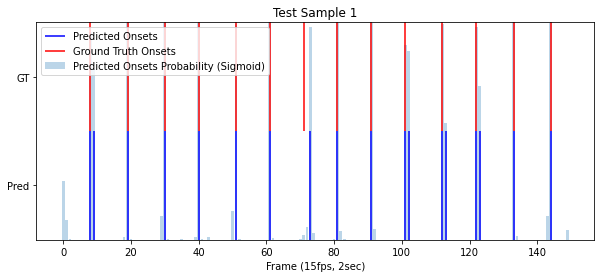

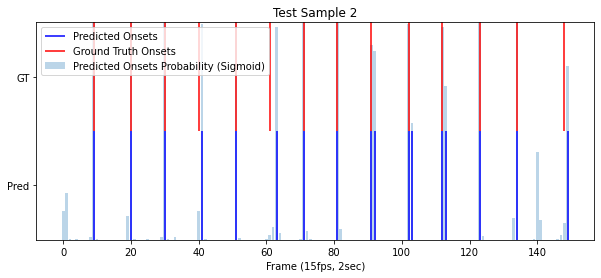

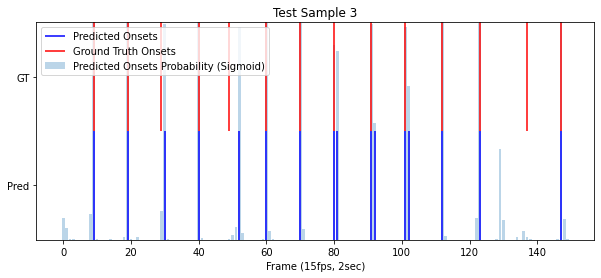

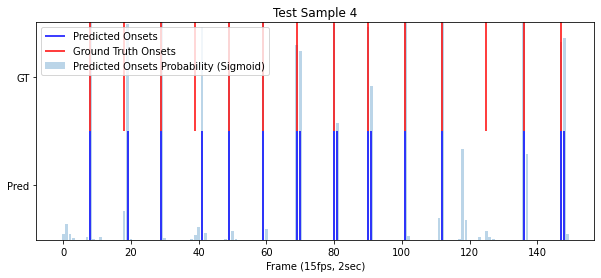

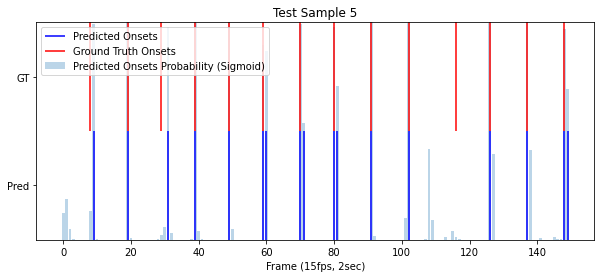

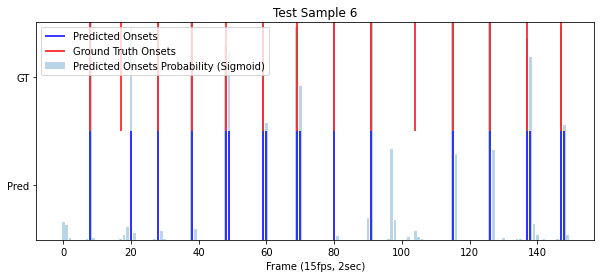

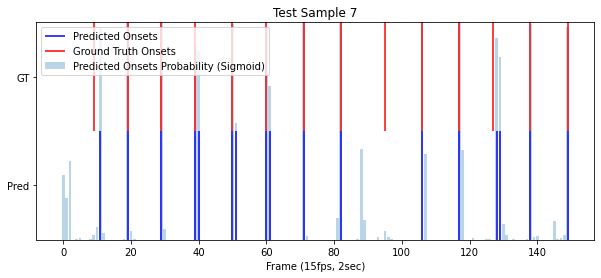

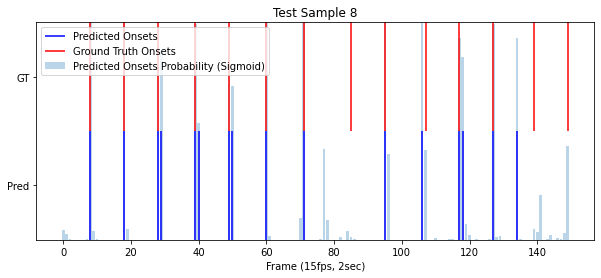

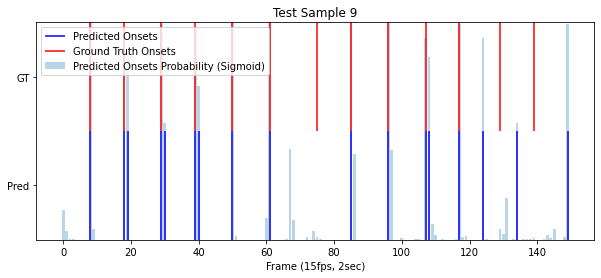

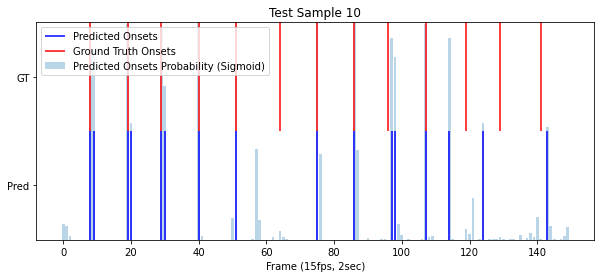

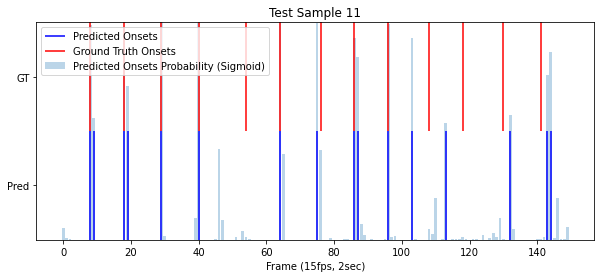

In [ ]:
# Model checkpoint
checkpoint_path = '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep40.pth.tar'
args = init_args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = data.GreatestHitDataset(args, split='test')
test_loader = DataLoader(
    test_dataset,
    batch_size=1,   # args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False)

net = models.VideoOnsetNet(pretrained=False).to(device)

# Load the trained model weights
net, _ = torch_utils.load_model(checkpoint_path, net, device=device, strict=True)
net.eval()

all_y_gt = []
all_y_pred = []
all_acc = []

for step, batch in enumerate(test_loader):
    inputs = {
        'frames': batch['frames'].to(device)
    }
    
    with torch.no_grad():
        pred = net(inputs)
    
    # Ground truth onsets
    target = batch['label'].to(device)
    target_np = target.cpu().numpy()
    pred_np = pred.cpu().numpy()
    
    logits = pred_np[0]
    
    # Sigmoid to pred_np
    pred_prob = 1 / (1 + np.exp(-pred_np))
    pred_np = np.where(pred_prob > 0.5, 1.0, 0.0)

    # target_np to frame
    target_frames = np.where(target_np[0] == 1)[0]
    target_times = librosa.samples_to_time(target_frames, sr=15)    # min: 0, maix: frame_len-1
    
    # pred_np to frame
    pred_frames = np.where(pred_np[0] == 1)[0]
    pred_times = librosa.samples_to_time(pred_frames, sr=15)        # min: 0, maix: frame_len-1
    
    # target_frames:  [  8  19  30  40  51  61  71  81  91 101 112 122 133 144] (15fps, 10sec)
    # pred_frames:  [  8  19  29  30  40  50  51  61  81  91 101 102 112 122 133 144] (15fps, 10sec)
    
    onset1 = target_times       # gt
    onset2 = pred_times         # pred
    
    # acc, ap, onset2_res, y_gt, y_pred = eval_onsets(onset1, onset2, logits)
    # all_y_gt.extend(y_gt)
    # all_y_pred.extend(y_pred)
    # all_acc.append(acc)
    # print(f"Test Sample {step+1} - Accuracy: {acc:.2f}, AP: {ap:.2f}")
    
    plt.figure(figsize=(10, 4)) 
    
    # Predicted onsets (Sigmoid)
    plt.bar(range(len(pred_prob[0])), pred_prob[0], alpha=0.3, label='Predicted Onsets Probability (Sigmoid)')
    
    # Predicted onsets
    pred_np = np.where(pred_np[0] == 1)[0]
    plt.vlines(pred_np, 0.0, 0.5, colors='b', linestyles='solid', label='Predicted Onsets')

    # Ground truth onsets
    target_np = np.where(target_np[0] == 1)[0]
    plt.vlines(target_np, 0.5, 1.0, colors='r', linestyles='solid', label='Ground Truth Onsets')
    
    plt.ylim(0, 1)
    plt.yticks([0.25, 0.75], ['Pred', 'GT'])
    plt.xlabel('Frame (15fps, 2sec)')
    plt.legend(loc='upper left')
    plt.title(f'Test Sample {step+1}')
    plt.show()
    
    if step >= 10:
        break

# Evaluate the model
# overall_acc = np.mean(all_acc)
# overall_ap = average_precision_score(all_y_gt, all_y_pred)

# print(f"Overall Test Set - Accuracy: {overall_acc:.2f}, AP: {overall_ap:.2f}")

# pr, rc, th = precision_recall_curve(all_y_gt, all_y_pred)
# plt.plot(rc, pr)
# plt.title(f'Precision-Recall Curve\nAP: {overall_ap:.2f}')
# plt.ylim((0, 1))
# plt.show()

In [6]:
import json
import glob
import soundfile as sf
import IPython.display as ipd


index = 0

list_sample = '/home/dabin/video2sound/CondFoleyGen/data/greatesthit_test_2.00.json'
with open(list_sample, "r") as f:
    list_sample = json.load(f)
if args.max_sample > 0:
    list_sample = list_sample[:args.max_sample]

info = list_sample[index].split('_')[0]
video_path = os.path.join('/home/dabin/video2sound/CondFoleyGen/data', 'greatesthit', 'greatesthit-process-resized', info)
frame_path = os.path.join(video_path, 'frames')
audio_path = os.path.join(video_path, 'audio')
audio_path = glob.glob(f"{audio_path}/*.wav")
audio_path = audio_path[0]
print("Audio path: ", audio_path)

audio, sr = sf.read(audio_path, start=0, stop=1000, dtype='float64', always_2d=True)

# Listen the sample audio in jupyter notebook
ipd.Audio(audio, rate=sr)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dabin/video2sound/CondFoleyGen/data/greatesthit_test_2.00.json'